In [256]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import optimize as opt

## Two dimensional example
Based on figure 1 in Sussillo and Barak 2013. Aim is to generate a simple 2D dyamical system and then use function q to find fixed and slow points which are candidates for linearization.

In [310]:
# Define a simple dynamical system with three fixed points
def F(x,t):
    x1, x2 = x
    
    x1d = (1-(x1**2)) * x2 
    x2d = (x1/2) - x2
    return [x1d,x2d]

In [311]:
# Now define function q to find fixed and slow points in the system F(x)
def q(x):
    t = 0 
    Fx = np.array(F(x,t))
    qx = (np.sum(abs(Fx)**2))/2
    return qx

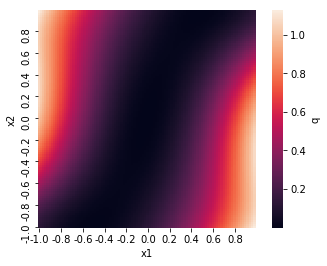

In [312]:
# calculate qx for every pair of x1 and x2
qx = np.zeros([100,100])
for i_ind, i in enumerate(np.linspace(-1,1,100)):
    for j_ind, j in enumerate(np.linspace(-1,1,100)):
        qx[i_ind, j_ind] = q(np.array([i,j]))

# plot heat map for values of q        
df = (pd.DataFrame(qx, 
      columns = np.round(np.linspace(-1,1,100),1),
      index = np.round(np.linspace(-1,1,100),1)))
ax = sns.heatmap(df, square=True, 
                 yticklabels=10, xticklabels=10,
                 cbar_kws={'label': 'q'})
ax.invert_yaxis()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [313]:
# Find local minima in q to identify fixed and slow points
x0 = np.array([(-1,-1), (0,0), (1,1)])
minima = np.zeros([3,2])
for i, x in enumerate(x0):
    sol = opt.minimize(q, x, method='Nelder-Mead', tol=1e-6)
    minima[i,:] = sol.x
minima

array([[-0.99999968, -0.49999966],
       [ 0.        ,  0.        ],
       [ 0.99999968,  0.49999966]])

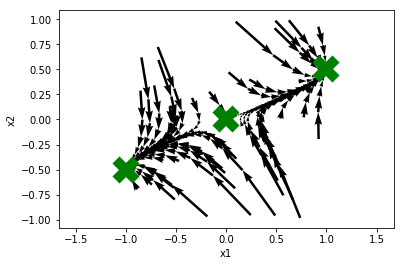

In [314]:
# randomly sample starting conditions between -1 and 1
x0 = [(-1 + 2*np.random.random(), -1 + 2*np.random.random()) 
      for i in range(50)]

# run the system from the various starting conditions 
# and plot trajectories
t = np.linspace(0,10,20)
plot = plt.figure()
for i, x in enumerate(x0):
    Fx = odeint(F, x, t)
    plt.quiver(Fx[:-1, 0], Fx[:-1, 1], # locations
               Fx[1:, 0]-Fx[:-1, 0], Fx[1:, 1]-Fx[:-1, 1], # values
               scale_units='xy', angles='xy', scale=1) 
    
# plot the minima we found for q - these are the fixed and slow points
plt.plot(minima[:,0], minima[:,1], "x", 
         markersize=20, markeredgewidth=10,
        markeredgecolor='g')
    
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

plt.show(plot)